### ECON 517 Assignment 8 (12/6/17)
### Rachel Anderson 

### Problem 1

The following code generates 200 observations from 

$$ 
y_i = x_i\beta + \epsilon_i $$

where $x_i \sim U[0,1]$, and $\epsilon_i = x_iv_i\ v_i \sim N(0,1)$.  The true value of $\beta$ is 1. 

In [1]:
%matplotlib notebook
import numpy as np
import scipy.io as spio
import matplotlib
import matplotlib.pyplot as plt
import sys
import pandas as pd
import random
import statsmodels.api as sm
import seaborn as sns

/Users/rachelanderson/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def gen_data(n):
    x = np.random.uniform(0,1,200) #generate x~unif[0,1]
    v = np.random.normal(0,1,200) #generate v ~ N(0,1)
    eps = x*v
    beta = 1
    y = x*beta + eps 
    return (x,y)

def do_ols(x,y,n):
    model = sm.OLS(y,x)
    results = model.fit()
    results.summary()
    beta_hat = results.params[0]
    e = y - x*beta_hat
    s2 = results.ssr/(n-1)
    return (beta_hat, e)

def t1(x,y,n):
    (beta_hat, e) = do_ols(x,y,n)
    s2 = np.dot(e,e)/(n-1)
    xx_inv = 1/(np.dot(x,x))
    avar1 = s2*xx_inv
    t1 = (beta_hat-1)/np.sqrt(avar1)
    return t1

def t2(x,y,n):
    (beta_hat, e) = do_ols(x,y,n)
    t = np.sum([(e[i]**2)*(x[i]**2) for i in range(len(e))])
    xx_inv = 1/(np.dot(x,x))
    avar2 = xx_inv*t*xx_inv
    t2 = (beta_hat-1)/np.sqrt(avar2)
    return t2

In [3]:
random.seed(10)
R=1000
n=200
def simulate(R,n):
    data = [gen_data(n) for i in range(R)] 
    t1t = [t1(data[i][0],data[i][1],n) for i in range(R)]
    t2t = [t2(data[i][0],data[i][1],n) for i in range(R)]
    t1_reject = [1 if np.absolute(t1t[i]) > 1.96 else 0 for i in range(len(t1t))]
    t2_reject = [1 if np.absolute(t2t[i]) > 1.96 else 0 for i in range(len(t2t))]
    return (np.sum(t1_reject),np.sum(t2_reject))

In [4]:
res = simulate(R,n)
print("The non-robust t-test rejects " + str(res[0]) + " of 1000 repetitions")
print("The robust t-test rejects " + str(res[1]) + " of 1000 repetitions")

The non-robust t-test rejects 146 of 1000 repetitions
The robust t-test rejects 69 of 1000 repetitions


**Note: ** The non-robust t-test, which uses the $s^2(X'X)^{-1}$ variance estimator, rejects at the $\alpha = 0.05$ level about 13 percent of the time, hence the test **over-rejects.**

The Eicker-White estimator of the variance of $\widehat{\beta}$, or the robust t-test, rejects at the $\alpha = 0.05$ level about 5 percent of the time, as desired.

### Problem 2

The following code generates $x_1, \dots, x_{100} \sim N(0,1)$ and $\epsilon_1, \dots, \epsilon_{100} \sim N(0,1)$, and constructs
$$ y_i = 1 + x_i + \epsilon_i$$

Then, replacing $x_1 = j$ for $j=$ 1, 10, 100, 10,00, 10,000, it performs OLS regression and calculates teh robust and non-robust t-statstic for the hypothesis $H_0: \beta = 1$. 

In [5]:
x = np.random.normal(0,1,100) #generate x~unif[0,1]
eps = np.random.normal(0,1,100) #generate v ~ N(0,1)
y = 1 + x + eps #construct y 
x1 = sm.add_constant(x) #add constant to OLS regression
model = sm.OLS(y,x1) #run ols, save parameters
results = model.fit()
results.summary()
beta_hat = results.params[1] 
e = y - results.params[0] - beta_hat*x #calculate residuals
xx_inv = 1/np.dot(x,x)  #(x'x)^(-1)
t1 = (beta_hat-1)/(np.sqrt((results.ssr/99)*xx_inv)) #nonrobust t-stat
s = np.sum([(e[i]**2)*(x[i]**2) for i in range(len(e))]) 
avar2 = xx_inv*s*xx_inv
t2 = (beta_hat-1)/np.sqrt(avar2) #robust t stat


<IPython.core.display.Javascript object>


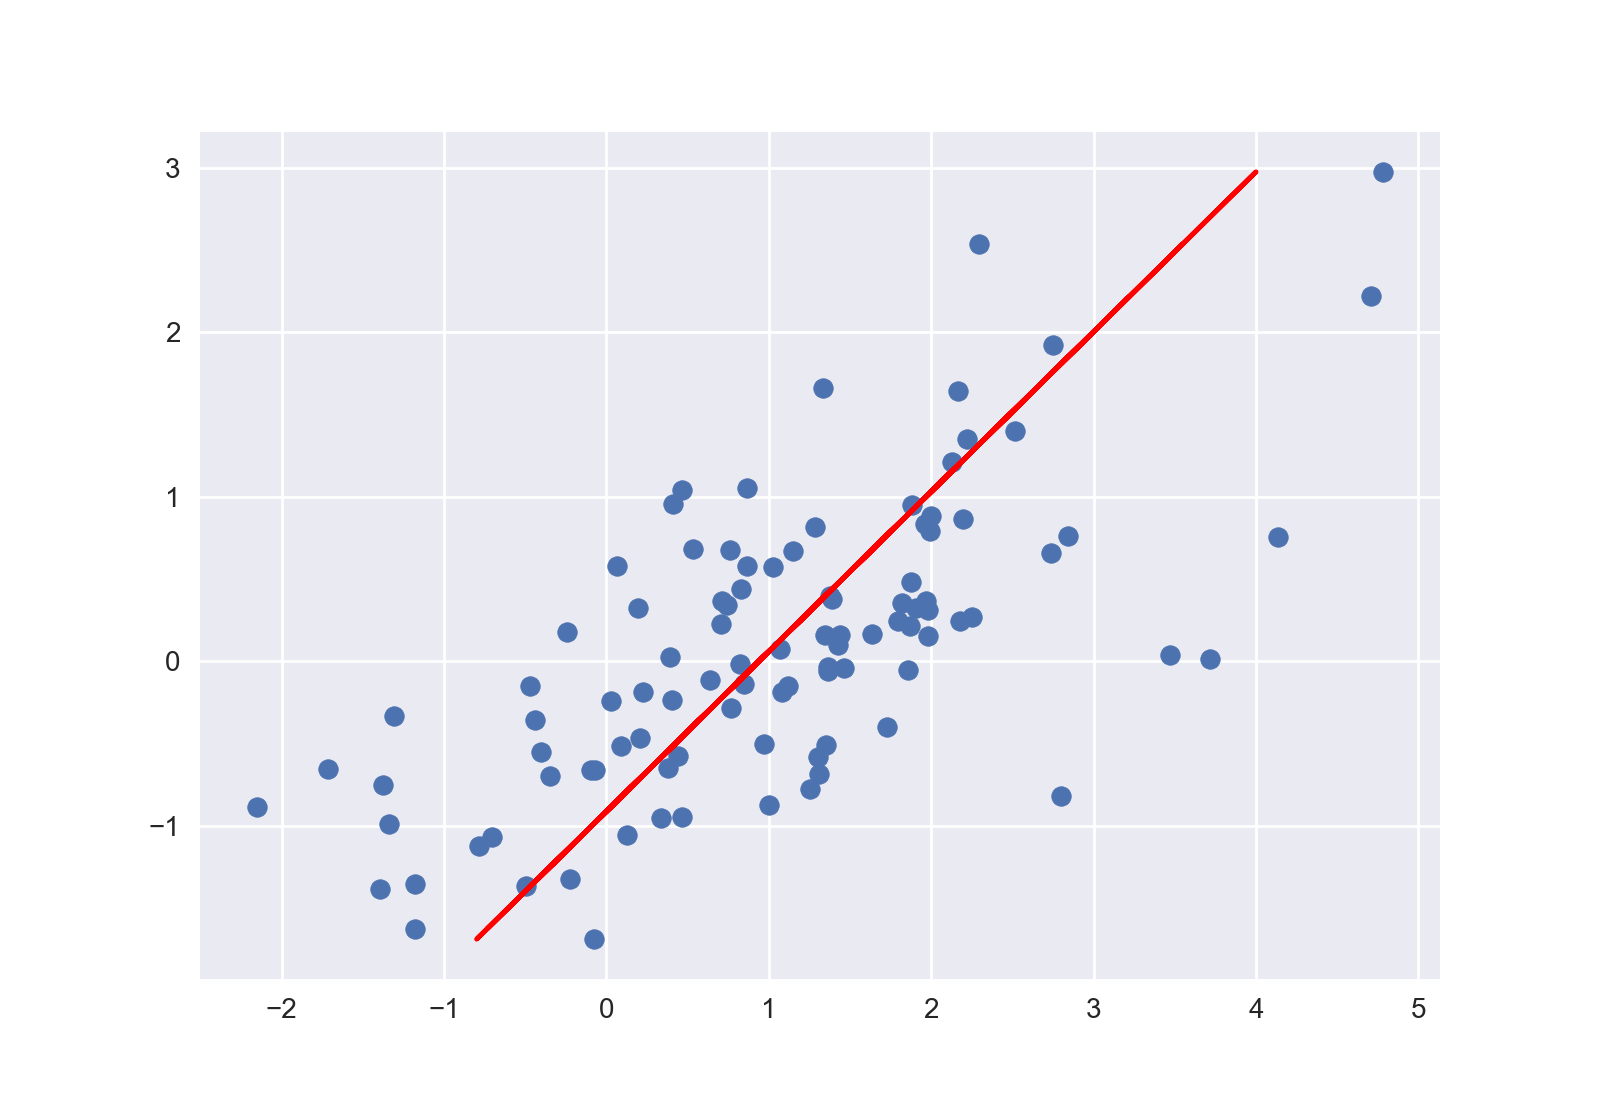

In [6]:
%matplotlib notebook
plt.figure(0)
plt.scatter(y,x)
plt.show()
ynew = results.predict(x1)
plt.plot(ynew,x, color="red")
plt.show()

In [186]:
print("The non-robust t-statistic is: " + str(t1) + " and the robust test statistic is: " + str(t2))
print("In other words, it does not seem to make much of a difference.")

The non-robust t-statistic is: 0.26429660881 and the robust test statistic is: 0.266857951869
In other words, it does not seem to make much of a difference.


In [187]:
def construct_x(j, x, y, x1, i):
    x[0] = j
    x1 = sm.add_constant(x) 
    model = sm.OLS(y,x1)
    results = model.fit()
    results.summary()
    beta_hat = results.params[1]
    e = y - results.params[0] - beta_hat*x
    xx = np.matmul(np.transpose(x1),x1)
    xx_inv = np.linalg.inv(xx)
    s2 = (np.sum([(e[i]**2) for i in range(len(e))])/98)
    avar1 = s2*xx_inv
    avar1=avar1[1][1]
    t1 = (beta_hat-1)/np.sqrt(avar1) #nonrobust
    s = np.sum([(e[i]**2) for i in range(len(e))])*xx
    avar2 = np.matmul(xx_inv, s)
    avar2 = np.matmul(avar2, xx_inv)
    avar2 = avar2[1][1]
    t2 = (beta_hat-1)/np.sqrt(avar2)
#     plt.scatter(x,y)
#     plt.plot(results.predict(x1),x1)
#     plt.show()
    return beta_hat, avar1, avar2, np.round(t1,3),np.round(t2,3)


In [188]:
nums = [1, 10, 100, 1000, 10000]
x = np.random.normal(0,1,100) #generate x~unif[0,1]
eps = np.random.normal(0,1,100) #generate v ~ N(0,1)
y = 1 + x + eps #construct y 
stats ={}
for i,j in enumerate(nums): 
#     plt.figure(i+1)
    stats[j] = construct_x(j, x, y, x1,i)

In [189]:
df = pd.DataFrame.from_dict(stats) 
df.index = ('beta_hat', 'avar1', 'avar2', 't1 (non-robust)', 't2 (robust)')
df

,1,10,100,1000,10000
beta_hat,1.186999,0.533029,0.011166,0.000303,2.204386e-05
avar1,0.012651,0.008991,0.000206,0.000002,2.082535e-08
avar2,1.239753,0.881080,0.020154,0.000204,2.040884e-06
t1 (non-robust),1.663000,-4.925000,-68.953000,-692.812000,-6.929378e+03
t2 (robust),0.168000,-0.497000,-6.965000,-69.985000,-6.999730e+02


**(1)**  Note that the assumptions in Hayashi are probabilistic statements about the data generating process.  What occurs in the simulations is a particularly unfortunate realization of the data, so that there are no violations of the Hayashi assumptions.

**(2)** The estimated model is $y_i = \hat{\beta}_0 + \hat{\beta}_1 x_i $.  First, we consider the asymptotic distribution of the non-robust t-statistic under the null,

$$t_{1} = \frac{\hat{\beta_1} - \beta_1}{\sqrt{s^2\left[\left(\sum_{i=1}^n x_i x_i'\right)^{-1}\right]_{22}}}$$

Start by observing that,

$$ \begin{pmatrix} \hat{\beta}_0 - \beta_0 \\ \hat{\beta}_1 -\beta_1 \end{pmatrix} = \underbrace{\frac{1}{n\sum_{i=1}^n x_i^2 + \left( \sum_{i=1}^n x_i\right) ^2} \begin{pmatrix} \sum_{i=1}^n x_i^2 & - \sum_{i=1}^n x_i \\ -  \sum_{i=1}^n  x_i & n \end{pmatrix}}_{(X'X)^{-1}} \begin{pmatrix}  \sum_{i=1}^n \epsilon_i \\  \sum_{i=1}^n x_i\epsilon_i \end{pmatrix}$$

so that 

$$  \hat{\beta}_1 -\beta_1 = \frac{\frac{1}{n}\sum_{i=1}^n x_i\epsilon_i - \frac{1}{n^2} \sum_{i=1}^n x_i \sum_{i=1}^n \epsilon_i }{\frac{1}{n}\sum_{i=1}^n x_i^2 - \frac{1}{n^2} \left(\sum_{i=1}^n x_i \right)^2}
$$

and as $n\to \infty$, certain terms dominate:
$$ \hat{\beta}_1 - \beta_1 \to \frac{\frac{1}{n}\sum_{i=1}^n x_i \epsilon_i}{\frac{1}{n} \sum_{i=1}^n  x_i^2} =  \frac{\frac{1}{n}\left(j\epsilon_1 + x_2 \epsilon_2 + \dots + x_{100}\epsilon_{100}\right)}{\frac{1}{n}\left(j^2 + x_2^2 + \dots + x_{100}^2\right)} = o(j^{-1})$$



And

$$ \widehat{Avar}_1(\hat{\beta_1}) = s^2 (X'X)^{-1}_{22}  = \underbrace{\left(\sum_{i=1}^n \epsilon_i + x_i'(\beta-{\hat{\beta}})\right)^2}_{O(j^2)}\underbrace{\frac{n}{n\sum_{i=1}^n x_i^2 + \left(\sum_{i=1}^n x_i\right)^2}}_{o(j^{-2})}$$ 



So that 
$$t_{1} = \frac{\hat{\beta_1} - \beta_1}{\sqrt{s^2\left[\left(\sum_{i=1}^n x_i x_i'\right)^{-1}\right]_{22}}} \approx \frac{o(j^{-1})}{\sqrt{O(j^2)o(j^{-2})}} = o(j^{-1}) \to 0 $$  

under the null, even as $j\to \infty$.  This works, furthermore, because we homoskedastic errors.

Alternatively, 

$$ \widehat{Avar}_2(\hat{\beta_1}) = (X'X)^{-1}(X'e'eX)(X'X)^{-1}  = O(j^-2) * O(j^4) * O(j^{-2}) = O(1)$$

and so 

$$t_{2} = \frac{\hat{\beta_1} - \beta_1}{\sqrt{\widehat{Avar}_2(\hat{\beta_1})_{22}}} \approx \frac{o(j^{-1})}{\sqrt{O(j^{-2})}} = O(1)$$  


**(3)** The bottom line is that the robust asymptotic variance estimator, while robust to heteroskedastic errors, is not robust to influential observations.  Hayashi's assumptions do not have any bite against particularly bad realizations of the data, and so it is necessary to be scrutinous when even applying the "robust" command in Stata.

**(4)** The easiest fix is to drop the outlier, but one could use nonparametric estimation techniques or choose an estimator that does not minimize MSE.
